<a href="https://colab.research.google.com/github/hrstt/profitable_ai_book_info/blob/master/notebooks/ac_01_heart_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 追加事例1 欠陥・疾患判定の自動化 (2値分類と再現率)

### 共通事前処理

In [1]:
# 日本語化ライブラリ導入
!pip install japanize-matplotlib | tail -n 1

In [3]:
# 共通事前処理

# 余分なワーニングを非表示にする
import warnings
warnings.filterwarnings('ignore')

# 必要ライブラリのimport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# matplotlib日本語化対応
import japanize_matplotlib

# データフレーム表示用関数
from IPython.display import display

# 表示オプション調整
# numpyの浮動小数点の表示精度
np.set_printoptions(suppress=True, precision=4)

# pandasでの浮動小数点の表示精度
pd.options.display.float_format = '{:.4f}'.format

# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)

# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14

# 乱数の種
random_seed = 123

In [4]:
# 混同行列表示用関数

def make_cm(matrix, columns):
    # matrix numpy配列
    
    # columns 項目名リスト
    n = len(columns)
    
    # '正解データ'をn回繰り返すリスト生成
    act = ['正解データ'] * n
    pred = ['予測結果'] * n
    
    #データフレーム生成
    cm = pd.DataFrame(matrix, 
        columns=[pred, columns], index=[act, columns])
    return cm

### A1.4 データ読み込みからデータ確認まで

### 項目メモ

#### age
年齢

#### sex
性別
* 1: 男性
* 0: 女性

#### cp
胸痛種別
* 1：典型的な狭心症
* 2：非定型狭心症
* 3：非狭心痛
* 4：無症候性 

#### trestbps
安静時血圧  
（入院時のmm Hg単位）
    
#### chol
血清コレステロール  
（mg / dl）

#### fbs
空腹時血糖   
(> 120 (mg / dl）)
* 1 真
* 0 偽

#### restecg
安静時心電図
 
* 0：通常
* 1：ST-T波異常（T波反転および/またはST上昇または抑圧> 0.05 mV）
* 2：左心室肥大の可能性あり

#### thalach
最大心拍数

#### exang
運動誘発性狭心症
* 1  はい
* 0  いいえ
    
#### oldpeak
ST低下    
(運動により誘発される安静時と比較したST低下)

#### slope
 STセグメント勾配  
(ピーク運動STセグメント勾配)
* 1 上昇
* 2 フラット  
* 3 下降

#### ca 
主要血管数  
(X線透視撮影で着色された主要な血管数（0〜3）)


#### thal
タール  
(タリウム心臓スキャンの結果) 
* 3: 通常
* 6 : 修正された欠陥
* 7 : 回復可能な欠陥


#### num (目的変数)
心臓病診断  
 （血管造影の状態）
* 0: 所見なし
* 1: 所見あり

#### データ読み込み

In [6]:
# 心疾患公開データ読み込み

columns = [
    '年齢', '性別', '胸痛種別', '安静時血圧',  '血清コレステロール',
    '空腹時血糖値', '安静時心電図',  '最大心拍数',  '運動誘発性狭心症',
    'ST低下', 'STセグメント勾配', '主要血管数', 'タール', '心臓病診断'
]

# 公開データセットのURL
url_hu = 'https://archive.ics.uci.edu/ml/machine-learning-databases/\
heart-disease/processed.hungarian.data'

# データフレームへの取り込み
# 欠損値は'?'で表現されているので、読み込み時にPythonのNaNに変換する
df_hu = pd.read_csv(url_hu, header=None, names=columns, na_values='?')

#### データ確認

In [7]:
# データ全体の確認
display(df_hu.head())

,年齢,性別,胸痛種別,安静時血圧,血清コレステロール,空腹時血糖値,安静時心電図,最大心拍数,運動誘発性狭心症,ST低下,STセグメント勾配,主要血管数,タール,心臓病診断
0,28,1,2,130.0000,132.0000,0.0000,2.0000,185.0000,0.0000,0.0000,nan,nan,nan,0
1,29,1,2,120.0000,243.0000,0.0000,0.0000,160.0000,0.0000,0.0000,nan,nan,nan,0
2,29,1,2,140.0000,nan,0.0000,0.0000,170.0000,0.0000,0.0000,nan,nan,nan,0
3,30,0,1,170.0000,237.0000,0.0000,1.0000,170.0000,0.0000,0.0000,nan,nan,6.0000,0
4,31,0,2,100.0000,219.0000,0.0000,1.0000,150.0000,0.0000,0.0000,nan,nan,nan,0


In [8]:
# 学習データ件数と項目数確認
print(df_hu.shape)
print()

# 「心臓病診断」の値の分布確認
print(df_hu['心臓病診断'].value_counts())
print()

# 所見あり比率
rate = df_hu['心臓病診断'].value_counts()[1]/len(df_hu)
print(f'有症率: {rate:.4f}')

(294, 14)

0    188
1    106
Name: 心臓病診断, dtype: int64

有症率: 0.3605


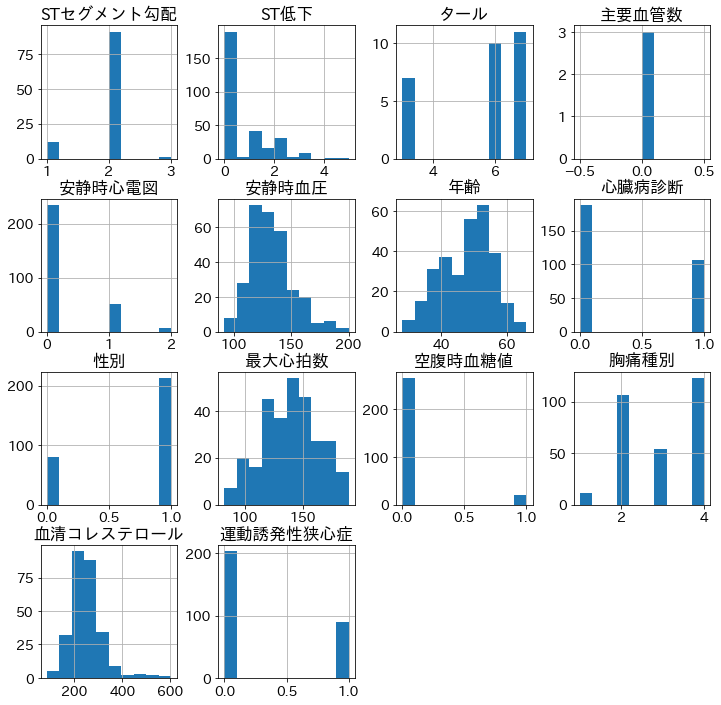

In [9]:
# ヒストグラム表示

# グラフのサイズ調整のためのおまじない
from pylab import rcParams
rcParams['figure.figsize'] = (12, 12)

# データフレームの数値項目でヒストグラム表示
df_hu.hist()
plt.show()

In [11]:
# 欠損値確認
print(df_hu.isnull().sum())

年齢             0
性別             0
胸痛種別           0
安静時血圧          1
血清コレステロール     23
空腹時血糖値         8
安静時心電図         1
最大心拍数          1
運動誘発性狭心症       1
ST低下           0
STセグメント勾配    190
主要血管数        291
タール          266
心臓病診断          0
dtype: int64


### A1.5 データ前処理とデータ分割

#### データ前処理

#### 欠損値対応方針

* 安静時血圧: 平均値
*  血清コレステロール: 平均値
* 空腹時血糖値: 0
* 安静時心電図: 0
* 最大心拍数: 平均値
* 運動誘発性狭心症: 0   
* STセグメント勾配: 2  
----    
* 主要血管数: 項目ごと落とす
* タール: 項目ごと落とす


In [12]:
# 平均値の計算
ave1 = df_hu['安静時血圧'].mean()
ave2 = df_hu['血清コレステロール'].mean()
ave3 = df_hu['最大心拍数'].mean()

# 結果確認
print(f'安静時血圧: {ave1:.1f}  血清コレステロール: {ave2:.1f}   最大心拍数:{ave3:.1f}')

安静時血圧: 132.6  血清コレステロール: 250.8   最大心拍数:139.1


In [13]:
# 欠損値の置換
df2 = df_hu.fillna(
    {'安静時血圧': ave1,
    '血清コレステロール': ave2,
    '空腹時血糖値': 0,
    '安静時心電図': 0,
    '最大心拍数': ave3,
    '運動誘発性狭心症': 0,
    'STセグメント勾配': 2}
)

# 列の削除
df3 = df2.drop(['主要血管数', 'タール'], axis=1)

In [14]:
# 結果確認
print(df3.isnull().sum())
display(df3.head())

年齢           0
性別           0
胸痛種別         0
安静時血圧        0
血清コレステロール    0
空腹時血糖値       0
安静時心電図       0
最大心拍数        0
運動誘発性狭心症     0
ST低下         0
STセグメント勾配    0
心臓病診断        0
dtype: int64


,年齢,性別,胸痛種別,安静時血圧,血清コレステロール,空腹時血糖値,安静時心電図,最大心拍数,運動誘発性狭心症,ST低下,STセグメント勾配,心臓病診断
0,28,1,2,130.0000,132.0000,0.0000,2.0000,185.0000,0.0000,0.0000,2.0000,0
1,29,1,2,120.0000,243.0000,0.0000,0.0000,160.0000,0.0000,0.0000,2.0000,0
2,29,1,2,140.0000,250.8487,0.0000,0.0000,170.0000,0.0000,0.0000,2.0000,0
3,30,0,1,170.0000,237.0000,0.0000,1.0000,170.0000,0.0000,0.0000,2.0000,0
4,31,0,2,100.0000,219.0000,0.0000,1.0000,150.0000,0.0000,0.0000,2.0000,0


#### データ分割

In [15]:
# 入力データと正解データの分離
x = df3.drop('心臓病診断', axis=1)
y = df3['心臓病診断'].values

# 訓練データと検証データの分離
test_size=0.40

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
  x, y, test_size=test_size, random_state=random_seed,
  stratify=y)

### A1.6 アルゴリズムの選定

#### アルゴリズム選定

In [17]:
# 候補アルゴリズムのリスト化

# ロジスティック回帰 (4.3.3)
from sklearn.linear_model import LogisticRegression
algorithm1 = LogisticRegression(random_state=random_seed)

# 決定木 (4.3.6)
from sklearn.tree import DecisionTreeClassifier
algorithm2 = DecisionTreeClassifier(random_state=random_seed)

# ランダムフォレスト (4.3.7)
from sklearn.ensemble import RandomForestClassifier
algorithm3 = RandomForestClassifier(random_state=random_seed)

# XGBoost (4.3.8)
from xgboost import XGBClassifier
algorithm4 = XGBClassifier(random_state=random_seed)

algorithms = [algorithm1, algorithm2, algorithm3, algorithm4]

In [18]:
# 交差検定法を用いて最適なアルゴリズムの選定

from sklearn.model_selection import StratifiedKFold
stratifiedkfold = StratifiedKFold(n_splits=3)

from sklearn.model_selection import cross_val_score
for algorithm in algorithms:
    # 交差検定法の実行
    scores = cross_val_score(algorithm , x_train, y_train,
        cv=stratifiedkfold, scoring='roc_auc')
    score = scores.mean()
    name = algorithm.__class__.__name__
    print(f'平均スコア: {score:.4f}  個別スコア: {scores}  {name}')

平均スコア: 0.8569  個別スコア: [0.8534 0.9323 0.7851]  LogisticRegression
平均スコア: 0.6994  個別スコア: [0.6936 0.8152 0.5894]  DecisionTreeClassifier
平均スコア: 0.8856  個別スコア: [0.8747 0.9449 0.8372]  RandomForestClassifier
平均スコア: 0.8402  個別スコア: [0.8221 0.9148 0.7838]  XGBClassifier


今回はランダムフォレストが一番性能がよかったので以降のアルゴリズムとして利用



### A1.7 学習・予測・評価

In [19]:
# アルゴリズム選定
# ランダムフォレストを選定
algorithm = RandomForestClassifier(random_state=random_seed)

# 学習
algorithm.fit(x_train, y_train)

# 予測
y_pred = algorithm.predict(x_test)

In [20]:
# 評価

# 混同行列を出力
from sklearn.metrics import confusion_matrix
df_matrix = make_cm(
    confusion_matrix(y_test, y_pred),
    ['所見なし', '所見あり'])
display(df_matrix)

# 適合率、再現率、F値を計算
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, 
    y_pred, average='binary')
print(f'適合率: {precision:.4f}  再現率: {recall:.4f}  F値: {fscore:.4f}')

予測結果     
           所見なし 所見あり
正解データ 所見なし   68    7
      所見あり   14   29

適合率: 0.8056  再現率: 0.6744  F値: 0.7342


### A1.8 チューニング

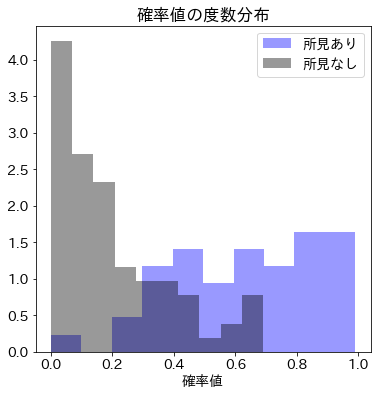

In [21]:
# 確率値の度数分布グラフ

# y=1の確率値取得
y_proba1= algorithm.predict_proba(x_test)[:,1]

# y_test=0 と y_test=1 でデータ分割
y0 = y_proba1[y_test==0]
y1 = y_proba1[y_test==1]

# 散布図描画
import seaborn as sns
plt.figure(figsize=(6,6))
plt.title('確率値の度数分布')
sns.distplot(y1, kde=False, norm_hist=True,
    bins=10,color='b', label='所見あり')
sns.distplot(y0, kde=False, norm_hist=True,
    bins=10,color='k', label='所見なし')
plt.xlabel('確率値')
plt.legend()
plt.show()

#### 閾値見直し

#### predict_proba関数を利用して、閾値0.5以外の場合の予測をする
(4.4節参照)

In [22]:
# 閾値を変更した場合の予測関数の定義
def pred(algorithm, x, thres):
    # 確率値の取得(行列)
    y_proba = algorithm.predict_proba(x)
    
    # 予測結果1の確率値
    y_proba1 =  y_proba[:,1]
    
    # 予測結果1の確率値 > 閾値
    y_pred = (y_proba1 > thres).astype(int)
    return y_pred

In [23]:
# 閾値を0.05刻みに変化させて、適合率, 再現率, F値を計算する
thres_list = np.arange(0.5, 0, -0.05)

for thres in thres_list:
    y_pred2 = pred(algorithm, x_test, thres)
    pred_sum =  y_pred2.sum()
    precision, recall, fscore, _ = precision_recall_fscore_support(
        y_test, y_pred2, average='binary')
    print(f'閾値: {thres:.2f} 合計: {pred_sum}  適合率: {precision:.4f}\
  再現率: {recall:.4f}  F値: {fscore:.4f})')

閾値: 0.50 合計: 36  適合率: 0.8056  再現率: 0.6744  F値: 0.7342)
閾値: 0.45 合計: 38  適合率: 0.7895  再現率: 0.6977  F値: 0.7407)
閾値: 0.40 合計: 46  適合率: 0.7391  再現率: 0.7907  F値: 0.7640)
閾値: 0.35 合計: 52  適合率: 0.7115  再現率: 0.8605  F値: 0.7789)
閾値: 0.30 合計: 58  適合率: 0.6724  再現率: 0.9070  F値: 0.7723)
閾値: 0.25 合計: 63  適合率: 0.6349  再現率: 0.9302  F値: 0.7547)
閾値: 0.20 合計: 68  適合率: 0.6029  再現率: 0.9535  F値: 0.7387)
閾値: 0.15 合計: 77  適合率: 0.5455  再現率: 0.9767  F値: 0.7000)
閾値: 0.10 合計: 84  適合率: 0.5000  再現率: 0.9767  F値: 0.6614)
閾値: 0.05 合計: 98  適合率: 0.4286  再現率: 0.9767  F値: 0.5957)


In [24]:
# 再現率重視で閾値を0.25にする
y_final = pred(algorithm, x_test, 0.25)

# 混同行列を出力
from sklearn.metrics import confusion_matrix
df_matrix4 = make_cm(
    confusion_matrix(y_test, y_final),
    ['所見なし', '所見あり'])
display(df_matrix4)

# 適合率、再現率、F値を計算
precision, recall, fscore, _ = precision_recall_fscore_support(
    y_test, y_final, average='binary')
print(f'適合率: {precision:.4f}  再現率: {recall:.4f}  F値: {fscore:.4f}')

予測結果     
           所見なし 所見あり
正解データ 所見なし   52   23
      所見あり    3   40

適合率: 0.6349  再現率: 0.9302  F値: 0.7547
